In [20]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Análisis exploratorio de datos

Este notebook se enfoca en el análisis de emociones en canciones y comentarios utilizando el modelo `roberta-base-goemotions` para la clasificación de texto. Se exploran dos datasets distintos y se evalúa la precisión del modelo en la predicción de emociones.

#### Descripción de los Datasets

- `songs_with_all_emotions.csv`: Contiene información de emociones para canciones, con valores de intensidad para cada emoción. Tiene los 28 tags del modelo original
- `songs_with_selected_emotions_500_words.csv`: Subconjunto de `songs_with_all_emotions.csv` con emociones seleccionadas para un análisis más específico. Esta procesado con el modelo re-entrenado
- `goemotions`, dataset precargado desde TensorFlow


In [36]:
data_with_all_emotions = pd.read_csv('datasets/songs_with_all_emotions.csv')
data_useful_emotions = pd.read_csv('datasets/songs_with_selected_emotions_500_words.csv')


Index(['Unnamed: 0.1', 'Unnamed: 0', 'ID', 'Name', 'Artist', 'Artist ID',
       'Language', 'Lyrics', 'annoyance', 'confusion', 'remorse', 'anger',
       'excitement', 'fear', 'love', 'disapproval', 'surprise', 'sadness',
       'amusement', 'relief', 'grief', 'realization', 'neutral', 'admiration',
       'disappointment', 'optimism', 'disgust', 'curiosity', 'caring',
       'nervousness', 'approval', 'gratitude', 'embarrassment', 'pride',
       'desire', 'joy'],
      dtype='object')

#### Análisis de Emociones

Se calcula la media de las emociones para identificar las más y menos presentes en los datasets. Este cálculo ayuda a comprender la distribución de las emociones en los datos.


In [7]:
suma_emociones = data_with_all_emotions[['annoyance', 'confusion', 'remorse', 'anger', 'excitement', 'fear', 'love', 'disapproval', 'surprise', 'sadness', 'amusement', 'relief', 'grief', 'realization', 'neutral', 'admiration', 'disappointment', 'optimism', 'disgust', 'curiosity', 'caring', 'nervousness', 'approval', 'gratitude', 'embarrassment', 'pride', 'desire', 'joy']].mean()

emociones_ordenadas = suma_emociones.sort_values(ascending=False)

print("Emociones más presentes:")
print(emociones_ordenadas.head())
print("\nEmociones menos presentes:")
print(emociones_ordenadas.tail())

Emociones más presentes:
neutral      0.739235
love         0.061538
sadness      0.036485
remorse      0.019520
amusement    0.018807
dtype: float64

Emociones menos presentes:
nervousness    0.002418
surprise       0.001831
grief          0.000672
relief         0.000507
pride          0.000266
dtype: float64


In [8]:
suma_emociones = data_useful_emotions[['joy', 'love', 'desire', 'gratitude', 'confusion', 'fear', 'nervousness', 'remorse', 'sadness', 'anger']].mean()

emociones_ordenadas = suma_emociones.sort_values(ascending=False)

print("% medio de emociones")
print(emociones_ordenadas)

% medio de emociones
love           0.060103
sadness        0.029621
joy            0.015983
remorse        0.012720
gratitude      0.012109
desire         0.008833
fear           0.008809
anger          0.006692
confusion      0.005445
nervousness    0.003074
dtype: float64


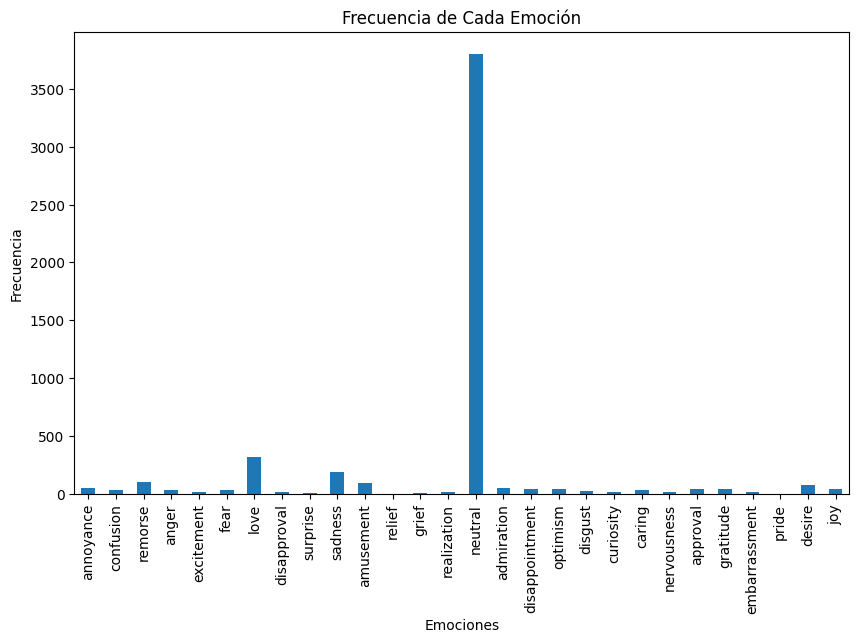

In [38]:
emotion_columns = ['annoyance', 'confusion', 'remorse', 'anger', 'excitement', 'fear', 'love', 'disapproval', 'surprise', 'sadness', 'amusement', 'relief', 'grief', 'realization', 'neutral', 'admiration', 'disappointment', 'optimism', 'disgust', 'curiosity', 'caring', 'nervousness', 'approval', 'gratitude', 'embarrassment', 'pride', 'desire', 'joy']

emotion_counts = data_with_all_emotions[emotion_columns].sum()

emotion_counts.plot(kind='bar', figsize=(10,  6))
plt.title('Frecuencia de Cada Emoción')
plt.xlabel('Emociones')
plt.ylabel('Frecuencia')
plt.show()

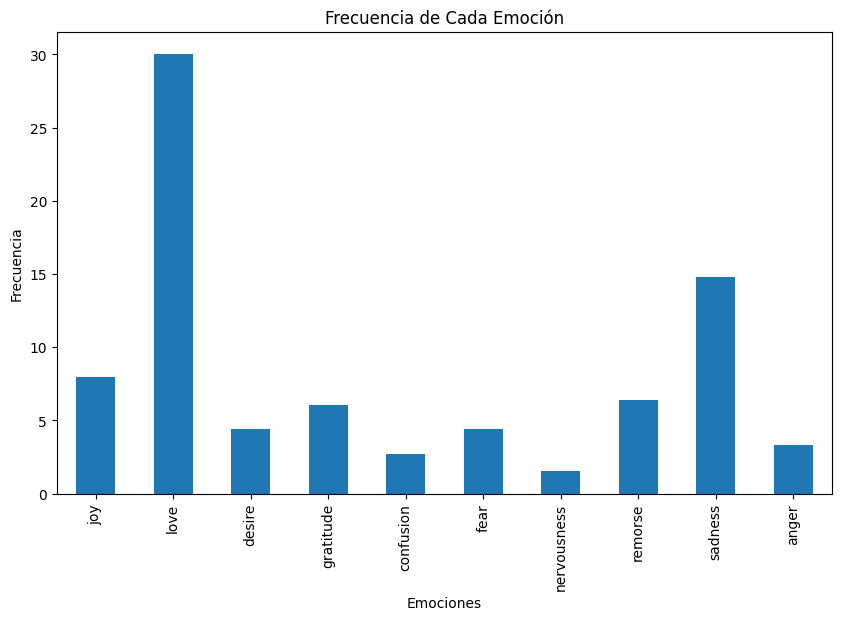

In [40]:
emotion_columns = ['joy', 'love', 'desire', 'gratitude', 'confusion', 'fear', 'nervousness', 'remorse', 'sadness', 'anger']

emotion_counts = data_useful_emotions[emotion_columns].sum()

emotion_counts.plot(kind='bar', figsize=(10,  6))
plt.title('Frecuencia de Cada Emoción')
plt.xlabel('Emociones')
plt.ylabel('Frecuencia')
plt.show()

### Verificación del Accuracy

#### Preparación de los Datos

Los datos se preparan para el modelo, incluyendo el preprocesamiento y la conversión de las emociones a números enteros para facilitar la evaluación.

#### Evaluación del Modelo

Se calcula el accuracy y se genera una matriz de confusión para evaluar el rendimiento del modelo en la predicción de emociones. Se utilizan métricas como precisión y recall para obtener una visión más completa del rendimiento.

In [19]:
df = pd.read_csv('datasets/manual_tagged.csv')
df.fillna(0, inplace=True)
columns_to_convert = ['anger', 'annoyance', 'confusion', 'desire', 'fear', 'gratitude', 'joy', 'love', 'nervousness', 'sadness']
df[columns_to_convert] = df[columns_to_convert].astype(int)

tokenizer = AutoTokenizer.from_pretrained("roberta-base-goemotions")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base-goemotions")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

predictions = classifier(list(df['Chorus']))

processed_predictions = [pred['label'] for pred in predictions]

true_labels = df[columns_to_convert].idxmax(axis=1).values.tolist()

accuracy = accuracy_score(true_labels, processed_predictions)

print(f'Accuracy: {accuracy}')

Accuracy: 0.26973684210526316


In [21]:
cm = confusion_matrix(true_labels, processed_predictions)

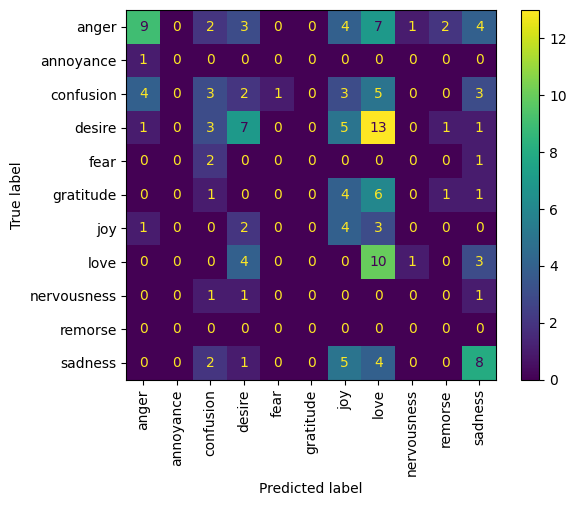

In [22]:
processed_predictions = [pred['label'] for pred in predictions]

unique_labels = np.unique(np.concatenate((true_labels, processed_predictions)))
class_labels = unique_labels.tolist()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.gca().set_xticklabels(class_labels, rotation='vertical')
plt.show()


In [24]:
precision = precision_score(true_labels, processed_predictions, average='macro')
recall = recall_score(true_labels, processed_predictions, average='macro')
print(f'Precisión: {precision}')
print(f'Recall: {recall}')


Precisión: 0.16897776465958286
Recall: 0.18231537727505467


c:\Users\Lau_d\Documents\Alexitune\venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lau_d\Documents\Alexitune\venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Trabajo con el Dataset GoEmotions

#### Carga y Preprocesamiento del Dataset GoEmotions

El dataset `goemotions` se carga y se prepara para el análisis, seleccionando columnas relevantes y manejando valores nulos.

#### Repetición del Proceso de Predicción

Se repite el proceso de predicción y evaluación con el dataset `goemotions` para comparar los resultados con los obtenidos con el dataset de canciones manualmente taggeadas.


In [29]:
goemotions_dataset, dataset_info = tfds.load('goemotions', split='validation', shuffle_files=True, with_info=True)

dataset_pd = tfds.as_dataframe(goemotions_dataset, ds_info=dataset_info)


In [30]:
columns_to_keep = ['comment_text', 'anger', 'annoyance', 'confusion', 'desire', 'fear', 'gratitude', 'joy', 'love', 'nervousness', 'sadness']

dataset = dataset_pd[columns_to_keep]

In [31]:
dataset['comment_text'] = dataset['comment_text'].astype(str).dropna()

C:\Users\Lau_d\AppData\Local\Temp\ipykernel_16940\2805189042.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['comment_text'] = dataset['comment_text'].astype(str).dropna()


In [32]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base-goemotions")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base-goemotions")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

predictions = classifier(list(dataset['comment_text']))

processed_predictions = [pred['label'] for pred in predictions]

true_labels = dataset[columns_to_keep[1:]].idxmax(axis=1).values.tolist()

accuracy = accuracy_score(true_labels, processed_predictions)

print(f'Accuracy: {accuracy}')

Accuracy: 0.38204939181717656


In [33]:
cm = confusion_matrix(true_labels, processed_predictions)

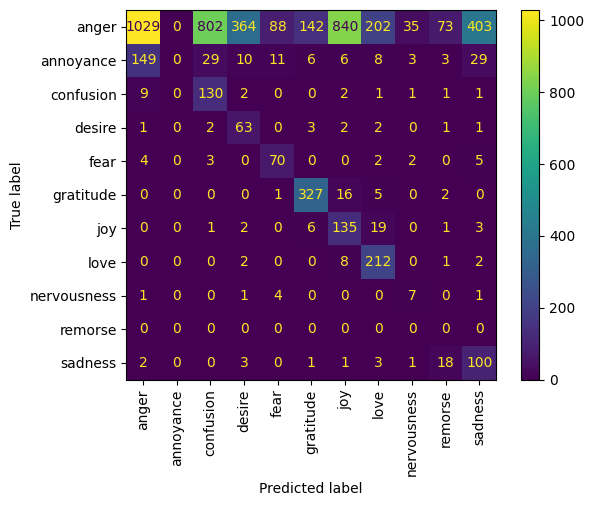

In [34]:
processed_predictions = [pred['label'] for pred in predictions]

unique_labels = np.unique(np.concatenate((true_labels, processed_predictions)))
class_labels = unique_labels.tolist()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.gca().set_xticklabels(class_labels, rotation='vertical')
plt.show()

In [35]:
precision = precision_score(true_labels, processed_predictions, average='macro')
recall = recall_score(true_labels, processed_predictions, average='macro')
print(f'Precisión: {precision}')
print(f'Recall: {recall}')

Precisión: 0.28545060177385384
Recall: 0.6140366468678693


c:\Users\Lau_d\Documents\Alexitune\venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lau_d\Documents\Alexitune\venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
